<a href="https://colab.research.google.com/github/matule00/SGE/blob/main/prace_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_weights
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

ImportError: cannot import name 'load_weights' from 'tensorflow.keras.models' (/usr/local/lib/python3.10/dist-packages/keras/_tf_keras/keras/models/__init__.py)

In [4]:
SVR = pd.read_csv('SVR_peak.csv')
SVR['Time'] = pd.to_datetime(SVR['Time'])

SVR = SVR.iloc[:-20]
#SVR = SVR[(SVR['prev_extrema_value'] <500) & (SVR['next_extrema_value'] <500)]

In [40]:
# Ensure the directory exists
os.makedirs("model_checkpoints", exist_ok=True)

# Define a valid checkpoint path
checkpoint_path = "model_checkpoints/weights.best.weights.h5"

# Create a callback to save the model's weights
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Only save the weights
    monitor='val_loss',      # Monitor validation loss
    mode='min',              # Save weights for minimum val_loss
    save_best_only=True,     # Save only the best weights
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


119/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2382.5117 - mse: 2382.5117
Epoch 1: val_loss improved from inf to 671.84552, saving model to model_checkpoints/weights.best.weights.h5
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2325.1189 - mse: 2325.1189 - val_loss: 671.8455 - val_mse: 671.8455 - learning_rate: 0.0010
Epoch 2/100
109/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 556.5767 - mse: 556.5767
Epoch 2: val_loss improved from 671.84552 to 525.05078, saving model to model_checkpoints/weights.best.weights.h5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 559.0179 - mse: 559.0179 - val_loss: 525.0508 - val_mse: 525.0508 - learning_rate: 0.0010
Epoch 3/100
123/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 492.6751 - mse: 492.6751
Epoch 3: val_loss improved from 525.05078 to 472.74796, saving model to model_checkpoints/weights.best.weights.h5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 494.2302 - mse: 494.2302 - val_loss: 472.7480 - val_mse: 472.7480 - learning_rate: 0.00

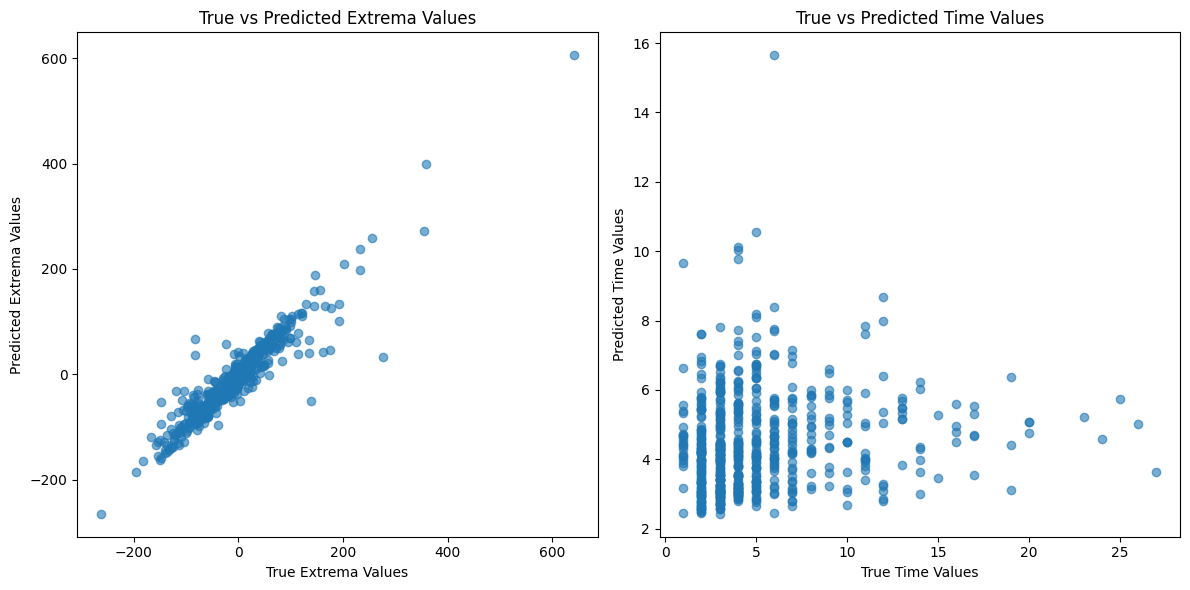

In [41]:
valid_rows = SVR.dropna(subset=['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                                'last_5_SVR_values_5'])
X = valid_rows[['time_prev', 'amp_diff', 'prev_extrema_value',
                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                'last_5_SVR_values_5']].values
y = valid_rows[['next_extrema_value', 'time_next']].values  # Two outputs: extrema and time

indices = valid_rows.index

# Split data into training and testing sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size=0.2, random_state=42)

# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model with two outputs
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),  # Added another layer for complexity
    Dropout(0.1),
    Dense(2)  # Output layer with 2 neurons: one for next_extrema_value and one for time_next
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping, lr_scheduler, checkpoint_callback], verbose=1)

# Evaluate the model
test_loss, test_mse = model.evaluate(X_test, y_test)
print(f"Test Mean Squared Error: {test_mse}")

# Predict and visualize both outputs
y_pred = model.predict(X_test)

# Separate predictions for both outputs
y_pred_extrema = y_pred[:, 0]  # Predictions for the extrema value
y_pred_time = y_pred[:, 1]  # Predictions for the time

# Separate true values for both outputs
y_test_extrema = y_test[:, 0]
y_test_time = y_test[:, 1]

# Calculate Mean Squared Error for both outputs
mse_extrema = mean_squared_error(y_test_extrema, y_pred_extrema)
mse_time = mean_squared_error(y_test_time, y_pred_time)

print(f"Mean Squared Error for Extrema: {mse_extrema}")
print(f"Mean Squared Error for Time: {mse_time}")


# Visualize True vs Predicted for Extrema Value
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_extrema, y_pred_extrema, alpha=0.6)
plt.xlabel('True Extrema Values')
plt.ylabel('Predicted Extrema Values')
plt.title('True vs Predicted Extrema Values')

# Visualize True vs Predicted for Time
plt.subplot(1, 2, 2)
plt.scatter(y_test_time, y_pred_time, alpha=0.6)
plt.xlabel('True Time Values')
plt.ylabel('Predicted Time Values')
plt.title('True vs Predicted Time Values')

plt.tight_layout()
plt.show()

In [62]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),  # Added another layer for complexity
    Dropout(0.1),
    Dense(2)  # Output layer with 2 neurons: one for next_extrema_value and one for time_next
])


valid_rows = SVR.dropna(subset=['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                                'last_5_SVR_values_5'])
X = valid_rows[['time_prev', 'amp_diff', 'prev_extrema_value',
                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                'last_5_SVR_values_5']].values
y = valid_rows[['next_extrema_value', 'time_next']].values  # Two outputs: extrema and time

indices = valid_rows.index

# Split data into training and testing sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size=0.2, random_state=42)

# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.load_weights('/content/model_checkpoints/weights.best.weights.h5')

y_pred1 = model.predict(X_test)
y_pred2 = model.predict(X_train)

y_pred = np.concatenate((y_pred1, y_pred2), axis=0)

y_test = np.concatenate((y_test, y_train), axis=0)

test_indices = np.concatenate((test_indices, train_indices), axis=0)

print(y_pred.shape)
print(y_test.shape)
print(test_indices.shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(3219, 2)
(3219, 2)
(3219,)


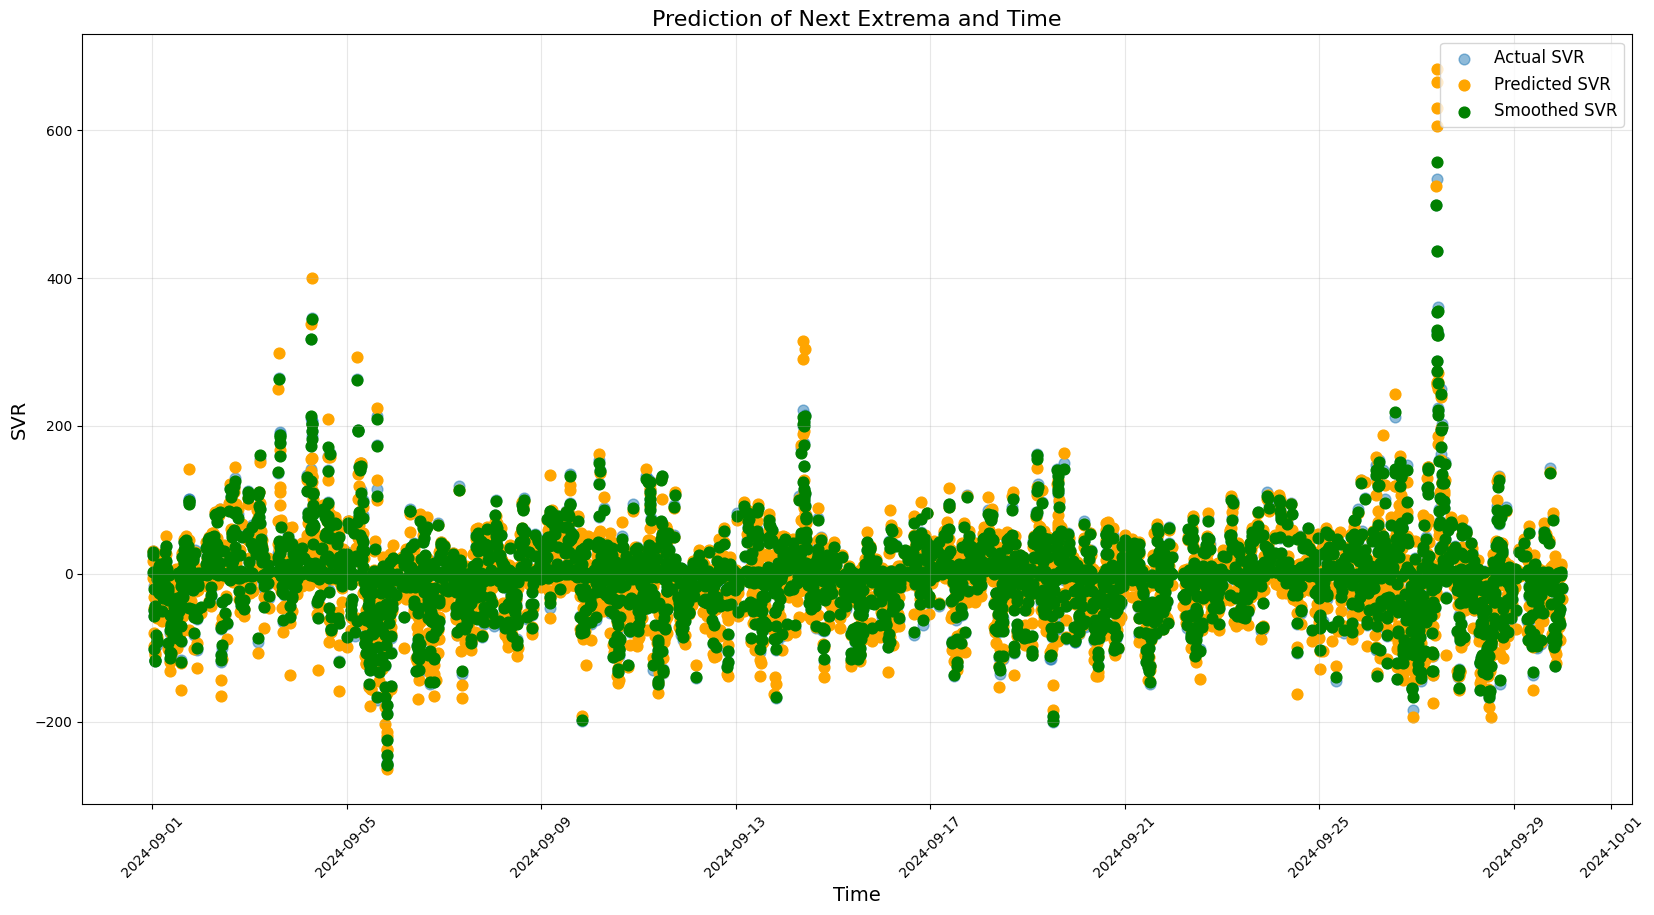

In [79]:
predictions = pd.DataFrame({
    'actual_value': y_test[:, 0],                # Actual extrema value
    'predicted_value': y_pred[:, 0],     # Predicted extrema value
    'actual_time': y_test[:, 1],                # Actual time to next extrema
    'predicted_time_offset': y_pred[:, 1],  # Predicted time offset
}, index=test_indices)  # Attach original indices

# Step 4: Calculate predicted time using the original SVR DataFrame
predicted_time_values = (
    SVR.loc[predictions.index, 'Time'] + pd.to_timedelta(predictions['predicted_time_offset'], unit='m')
)
predictions['predicted_time'] = predicted_time_values

# Step 5: Find SVR values at predicted times
actual_svr_at_predicted_time = []
smoothed_svr = []

for predicted_time in predicted_time_values:
    closest_idx = (SVR['Time'] - predicted_time).abs().idxmin()
    actual_svr_at_predicted_time.append(SVR.loc[closest_idx, 'SVR'])
    smoothed_svr.append(SVR.loc[closest_idx, 'smoothed_SVR'])

# Add SVR values to the DataFrame
predictions['actual_svr_at_predicted_time'] = actual_svr_at_predicted_time
predictions['smoothed_SVR_at_predicted_time'] = smoothed_svr

'''
# Step 6: Optional filtering for specific ranges
predictions = predictions[
    (predictions['predicted_value'] > 150)
]
'''


# Step 7: Visualization
plt.figure(figsize=(20, 10))
plt.scatter(predictions['predicted_time'], predictions['actual_svr_at_predicted_time'], label='Actual SVR', alpha=0.5, s=60)
plt.scatter(predictions['predicted_time'], predictions['predicted_value'], label='Predicted SVR', color='orange', s=60)
plt.scatter(predictions['predicted_time'], predictions['smoothed_SVR_at_predicted_time'], label='Smoothed SVR', color='green', s=60)
plt.title('Prediction of Next Extrema and Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('SVR', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

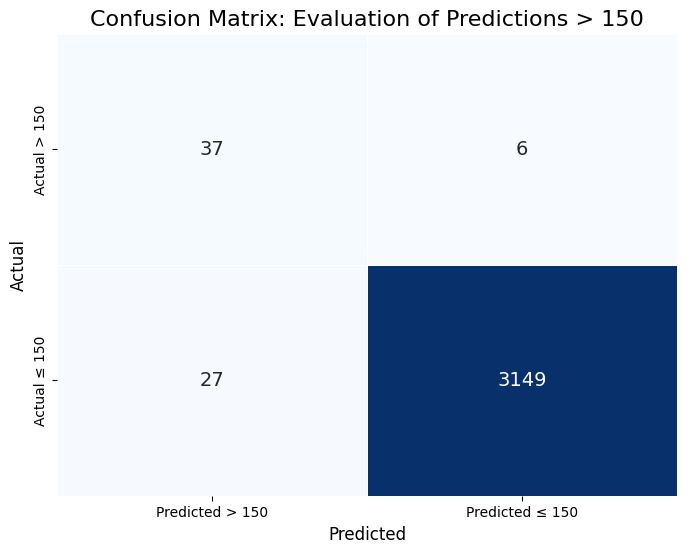

Total predictions (all values): 3219
Actual extrema > 150: 3186
Percentage of correct predictions: 98.97%
Mean Squared Error (excluding True Negatives): 6730.7227
Mean Standard Deviation Error (excluding True Negatives): 82.0410


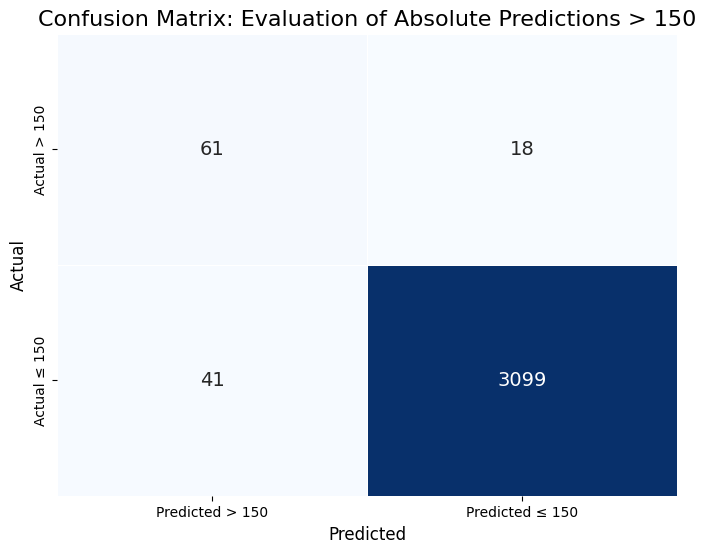

Total predictions (all values): 3219
Correct predictions (TP + TN): 3160
Percentage of correct predictions: 98.17%
Mean Squared Error (excluding True Negatives): 4470.2298
Mean Standard Deviation Error (excluding True Negatives): 66.8598


In [103]:
import seaborn as sns


def evaluate_predictions(predictions, threshold):
    """
    Evaluates the predictions based on a given threshold and plots a confusion matrix heatmap.
    Computes Mean Squared Error (MSE) for the predictions (excluding True Negatives).

    Parameters:
        predictions (pd.DataFrame): DataFrame with actual and predicted values.
        threshold (float): The threshold value to classify predictions as > threshold or ≤ threshold.
    """
    # Step 1: Create the confusion matrix categories directly
    TP = ((predictions['actual_value'] > threshold) & (predictions['predicted_value'] > threshold)).sum()  # True Positive
    FP = ((predictions['actual_value'] <= threshold) & (predictions['predicted_value'] > threshold)).sum()  # False Positive
    TN = ((predictions['actual_value'] <= threshold) & (predictions['predicted_value'] <= threshold)).sum()  # True Negative
    FN = ((predictions['actual_value'] > threshold) & (predictions['predicted_value'] <= threshold)).sum()  # False Negative

    # Step 2: Calculate MSE excluding True Negatives (only for TP, FP, FN)
    predictions_non_tn = predictions[(predictions['actual_value'] > threshold) | (predictions['predicted_value'] > threshold)]
    mse = mean_squared_error(predictions_non_tn['actual_value'], predictions_non_tn['predicted_value'])

    # Step 3: Create the confusion matrix
    conf_matrix = pd.DataFrame([[TP, FP], [FN, TN]],
                               columns=[f'Predicted > {threshold}', f'Predicted ≤ {threshold}'],
                               index=[f'Actual > {threshold}', f'Actual ≤ {threshold}'])

    # Step 4: Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={'size': 14}, linewidths=0.5)
    plt.title(f'Confusion Matrix: Evaluation of Predictions > {threshold}', fontsize=16)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()

    # Additional metrics: Percentage of correct predictions
    total_predictions = TP + TN + FP + FN
    correct_predictions = TP + TN
    percentage_correct = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

    # Print results
    print(f"Total predictions (all values): {total_predictions}")
    print(f"Actual extrema > {threshold}: {correct_predictions}")
    print(f"Percentage of correct predictions: {percentage_correct:.2f}%")
    print(f"Mean Squared Error (excluding True Negatives): {mse:.4f}")
    print(f"Mean Standard Deviation Error (excluding True Negatives): {np.sqrt(mse):.4f}")

def evaluate_predictions_absolute(predictions, threshold):
    """
    Evaluates the predictions based on a given threshold using absolute values for both predictions and actual values.
    Computes Mean Squared Error (MSE) for the predictions (excluding True Negatives).

    Parameters:
        predictions (pd.DataFrame): DataFrame with actual and predicted values.
        threshold (float): The threshold value to classify predictions as > threshold or ≤ threshold.
    """
    # Step 1: Convert actual and predicted values into absolute values
    predictions['abs_actual_value'] = np.abs(predictions['actual_value'])
    predictions['abs_predicted_value'] = np.abs(predictions['predicted_value'])

    # Step 2: Define the conditions for True Positives, False Positives, True Negatives, and False Negatives
    TP = ((predictions['abs_actual_value'] > threshold) & (predictions['abs_predicted_value'] > threshold)).sum()  # True Positive
    FP = ((predictions['abs_actual_value'] <= threshold) & (predictions['abs_predicted_value'] > threshold)).sum()  # False Positive
    TN = ((predictions['abs_actual_value'] <= threshold) & (predictions['abs_predicted_value'] <= threshold)).sum()  # True Negative
    FN = ((predictions['abs_actual_value'] > threshold) & (predictions['abs_predicted_value'] <= threshold)).sum()  # False Negative

    # Step 3: Calculate MSE excluding True Negatives (only for TP, FP, FN)
    predictions_non_tn = predictions[(predictions['abs_actual_value'] > threshold) |
                                     (predictions['abs_predicted_value'] > threshold)]
    mse = mean_squared_error(predictions_non_tn['actual_value'], predictions_non_tn['predicted_value'])

    # Step 4: Create the confusion matrix
    conf_matrix = pd.DataFrame([[TP, FP], [FN, TN]],
                               columns=[f'Predicted > {threshold}', f'Predicted ≤ {threshold}'],
                               index=[f'Actual > {threshold}', f'Actual ≤ {threshold}'])

    # Step 5: Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={'size': 14}, linewidths=0.5)
    plt.title(f'Confusion Matrix: Evaluation of Absolute Predictions > {threshold}', fontsize=16)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()

    # Additional metrics: Percentage of correct predictions
    total_predictions = TP + TN + FP + FN
    correct_predictions = TP + TN
    percentage_correct = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

    # Print results
    print(f"Total predictions (all values): {total_predictions}")
    print(f"Correct predictions (TP + TN): {correct_predictions}")
    print(f"Percentage of correct predictions: {percentage_correct:.2f}%")
    print(f"Mean Squared Error (excluding True Negatives): {mse:.4f}")
    print(f"Mean Standard Deviation Error (excluding True Negatives): {np.sqrt(mse):.4f}")


# Example usage
evaluate_predictions(predictions, 150)
evaluate_predictions_absolute(predictions, 150)
